# Discovering faster matrix multiplication algorithms with reinforcement learning
### By Alexander Novikov and co. 
05.10.2022


Использование обучения с подкреплением для поиска алгоритма перемножения матриц. В силу того, что алгоритм умножения матриц можно представить в виде тензора, задачу можно сформулировать как поиск разложения тензора ${{\mathscr{T}}}_{n}$
$${{\mathscr{T}}}_{n}={\sum }_{r=1}^{R}{{\bf{u}}}^{(r)}\otimes {{\bf{v}}}^{(r)}\otimes {{\bf{w}}}^{(r)}$$
Таким образом, количество скалярных произведений будет соответсвовать ${R}$

(NP-полная)

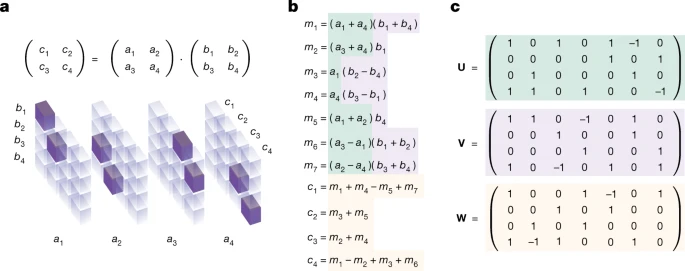

## Алгоритм обучения с подкреплением

В начальный момент времени текущее состояние задано тензором, определяющего операцию умножения матриц. На каждом шаге ${i}$ состояние обновляется вычитанием из текущего тензора ${{\mathscr{T}}}_{i - 1}$, построенного алгоритмом тензора ${{\bf{u}}}^{(i)}\otimes {{\bf{v}}}^{(i)}\otimes {{\bf{w}}}^{(i)}$

AlphaTensor - агент, играющий в вышеописанный TensorGame. Для перемещения по дереву поиска Монте Карло (Monte Carlo tree search) AlphaTensor использует глубкоую нейронную сеть, которая принимает на вход текущее состояние (тензор) и выдает стратегию (policy) и ожидаемый выигрыш (value). 

Нейронная сеть имеет архитектуру трансформер. Механизм внимания трансформеров моделирует взаимодействие элементов тензора друг с другом и учитывает инвариантность ранга тензора к перестановке осей. Представление тензора подается на вход в policy head и value head.

При проходе по дереву Монте Карло следующее действие выбирается по формуле:
$$\mathop{{\rm{argmax}}}\limits_{a}Q(s,a)+c(s)\cdot \hat{\pi }(s,a)\frac{\sqrt{{\sum }_{b}N(s,b)}}{1+N(s,a)}$$
После заверешения игры, она подается в алгоритм обучения нейронной сети для обновления параметров.

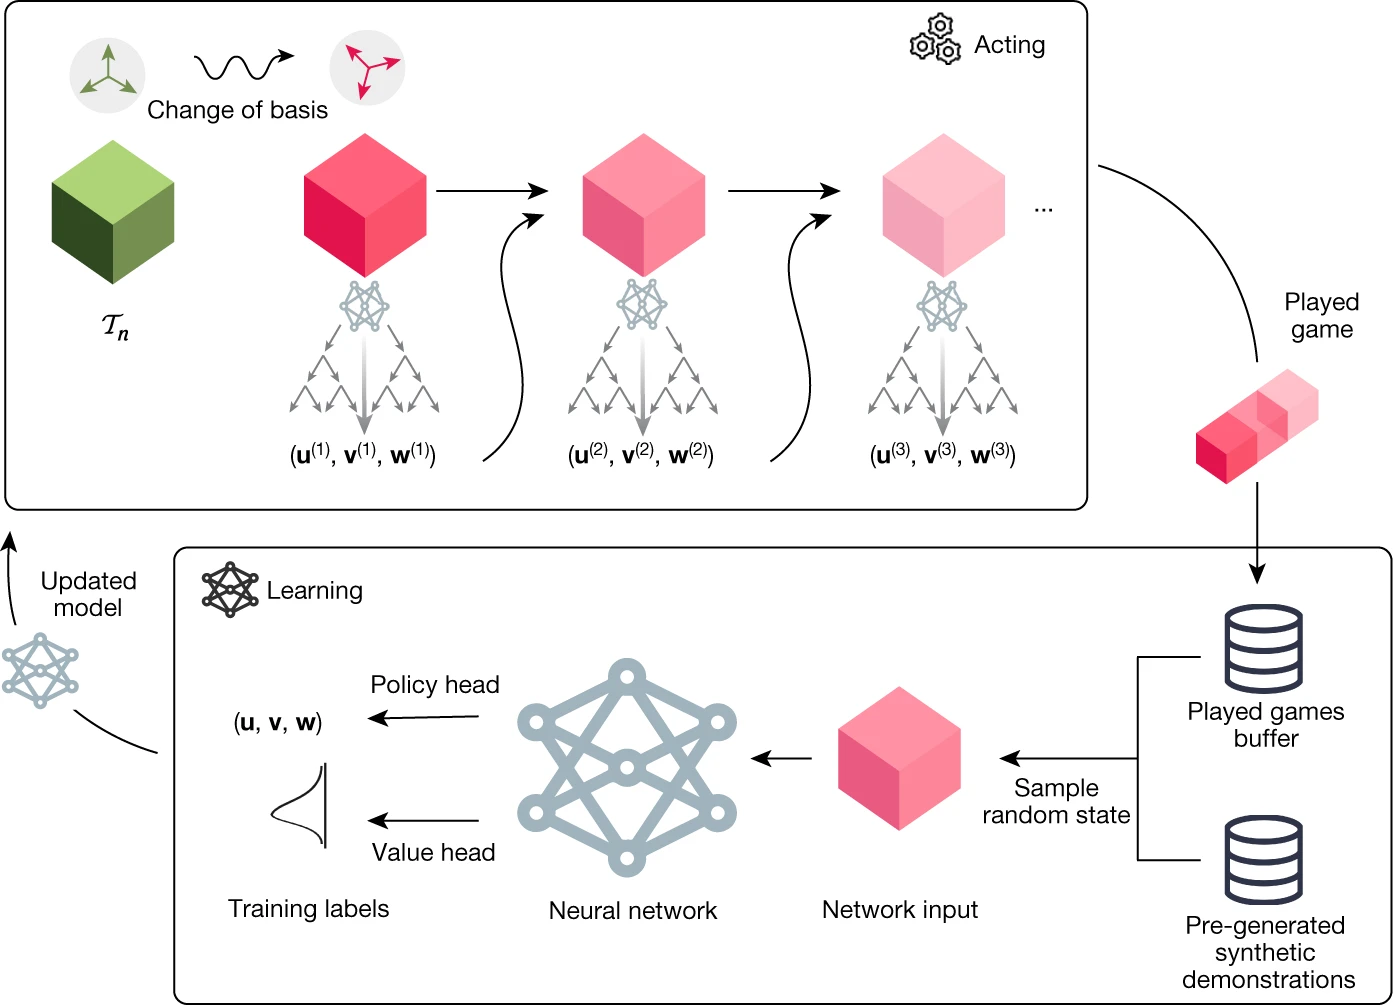

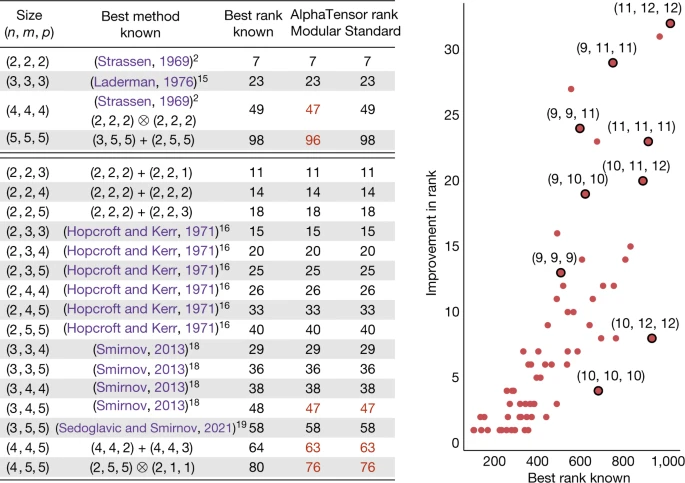

In [1]:
import numpy as np

In [ ]:
filename = '../alphatensor/algorithms/factorizations_r.npz'
with open(filename, 'rb') as f:
    factorizations = dict(np.load(f, allow_pickle=True))

In [279]:
for key in factorizations:
    u, v, w = factorizations[key]
    rank = u.shape[-1]
    assert rank == v.shape[-1] and rank == w.shape[-1]
    print(f'{key}: rank={u.shape[-1]}')

2,2,2: rank=7
2,2,3: rank=11
2,2,4: rank=14
2,2,5: rank=18
2,2,6: rank=21
2,2,7: rank=25
2,2,8: rank=28
2,3,3: rank=15
2,3,4: rank=20
2,3,5: rank=25
2,4,4: rank=26
2,4,5: rank=33
2,5,5: rank=40
3,3,3: rank=23
3,3,4: rank=29
3,3,5: rank=36
3,4,4: rank=38
3,4,5: rank=47
3,4,11: rank=103
3,5,5: rank=58
3,5,9: rank=105
3,9,11: rank=225
4,4,4: rank=49
4,4,5: rank=63
4,5,5: rank=76
4,5,9: rank=139
4,5,10: rank=152
4,5,11: rank=169
4,9,10: rank=255
4,9,11: rank=280
4,11,11: rank=343
4,11,12: rank=366
5,5,5: rank=98
5,5,7: rank=134
5,7,9: rank=234
5,7,10: rank=257
5,7,11: rank=280
5,8,9: rank=262
5,8,10: rank=287
5,8,11: rank=317
5,9,9: rank=296
5,9,10: rank=323
5,9,11: rank=358
5,9,12: rank=381
6,7,9: rank=270
6,7,10: rank=296
6,7,11: rank=322
6,8,10: rank=329
6,8,11: rank=365
6,9,9: rank=342
6,9,10: rank=373
6,9,11: rank=411
7,7,9: rank=318
7,7,10: rank=350
7,7,11: rank=384
7,8,9: rank=354
7,8,10: rank=393
7,8,11: rank=432
7,8,12: rank=462
7,9,9: rank=399
7,9,10: rank=441
7,9,11: rank=481
7,

In [282]:
def mul_product(a, b):
    shape = f'{a.shape[0]},{a.shape[1]},{b.shape[-1]}'
    u, v, w = factorizations[shape]
#     print(f'rank={u.shape[-1]}')
    m = np.sum(u.T * a.flatten(), axis=1) * np.sum(v.T * b.flatten(), axis=1)
    c = np.sum(w * m, axis=1).reshape(b.shape[-1], a.shape[0]).T
    return c

In [283]:
def mul_product2(a, b):
    shape = f'{a.shape[0]},{a.shape[1]},{b.shape[-1]}'
    u, v, w = factorizations[shape]

    rank = u.shape[-1]
#     print(f'rank={rank}')

    a_flat = a.flatten()
    m_a = [0] * rank
    for r in range(rank):
        for i in range(len(a_flat)):
            for k in range(abs(u[i][r])):
                if u[i][r] > 0:
                    m_a[r] += a_flat[i]
                else:
                    m_a[r] -= a_flat[i]

    b_flat = b.flatten()
    m_b = [0] * rank
    for r in range(rank):
        for i in range(len(b_flat)):
            for k in range(abs(v[i][r])):
                if v[i][r] > 0:
                    m_b[r] += b_flat[i]
                else:
                    m_b[r] -= b_flat[i]

    m = np.array(m_a) * np.array(m_b)

    c = [0] * (a.shape[0] * b.shape[-1])
    for i in range(len(c)):
        for r in range(rank):
            for k in range(abs(w[i][r])):
                if w[i][r] > 0:
                    c[i] += m[r]
                else:
                    c[i] -= m[r]
    c = np.array(c).reshape(b.shape[-1], a.shape[0]).T
    return c

def sign(a):
    return bool(a > 0) - bool(a < 0)

In [284]:
for key in factorizations:
    print(key)
    u, v, w = factorizations[key]
    shape = key.split(',')
    a = np.random.rand(int(shape[0]), int(shape[1]))
    b = np.random.rand(int(shape[1]), int(shape[2]))

    c_gr_truth = a @ b
    try:
        c = mul_product(a, b)
    #     print(f'a @ b:\n{c_gr_truth}\n\nmul_product(a, b):\n{c}')
        print((np.abs(c_gr_truth - c) < 1e-12).all())
    except:
        continue

    try:
        c = mul_product2(a, b)
    #     print(f'a @ b:\n{c_gr_truth}\n\nmul_product(a, b):\n{c}')
        print((np.abs(c_gr_truth - c) < 1e-12).all())
    except:
        print('error')
        continue
#     break

2,2,2
True
True
2,2,3
True
True
2,2,4
True
True
2,2,5
True
True
2,2,6
True
True
2,2,7
True
True
2,2,8
True
True
2,3,3
True
True
2,3,4
True
True
2,3,5
True
True
2,4,4
True
True
2,4,5
True
True
2,5,5
True
True
3,3,3
True
True
3,3,4
True
True
3,3,5
True
True
3,4,4
True
True
3,4,5
True
True
3,4,11
True
error
3,5,5
True
True
3,5,9
True
True
3,9,11
True
error
4,4,4
True
True
4,4,5
True
True
4,5,5
True
True
4,5,9
True
True
4,5,10
True
True
4,5,11
True
error
4,9,10
True
True
4,9,11
True
True
4,11,11
True
True
4,11,12
True
True
5,5,5
True
True
5,5,7
True
True
5,7,9
True
True
5,7,10
True
True
5,7,11
True
error
5,8,9
True
True
5,8,10
True
True
5,8,11
True
error
5,9,9
True
True
5,9,10
True
True
5,9,11
True
True
5,9,12
True
True
6,7,9
True
True
6,7,10
True
True
6,7,11
True
error
6,8,10
True
True
6,8,11
True
error
6,9,9
True
True
6,9,10
True
True
6,9,11
True
True
7,7,9
True
True
7,7,10
True
True
7,7,11
True
error
7,8,9
True
True
7,8,10
True
True
7,8,11
True
True
7,8,12
True
True
7,9,9
True
True
7,9,

In [278]:
factorizations['3,4,11']

array([array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
              [ 0.,  0.,  0., ...,  1.,  0.,  1.],
              [ 0.,  0.,  0., ...,  0.,  0.,  1.],
              ...,
              [ 0., -1.,  0., ...,  1.,  1.,  0.],
              [ 0.,  0.,  0., ...,  0.,  1.,  0.],
              [ 0., -1.,  0., ...,  0., -1.,  0.]]),
       array([[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
              [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
              [ 0. ,  0. , -1. , ...,  0. ,  0. ,  0. ],
              ...,
              [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
              [ 0. ,  0. ,  0. , ...,  1. ,  0. ,  0. ],
              [ 0. ,  0. ,  0. , ..., -1. ,  0.5,  0. ]]),
       array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
              [ 0.,  0., -1., ...,  0.,  0.,  0.],
              [ 0.,  0.,  0., ...,  0.,  0.,  0.],
              ...,
              [ 0.,  0.,  0., ...,  0.,  0.,  0.],
              [ 0.,  0.,  0., ...,  0.,  0.,  0.],
              [ 0.,  0.,  0., ...,  

In [291]:
6.51 / (46.88 / 4)

0.5554607508532423